In [4]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

In [5]:
import palantir 
import phenograph
import harmony

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [6]:
sns.set_style('white')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

In [7]:
%matplotlib inline

# Utility functions

In [8]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [9]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr

# Load data

## ATAC

In [10]:
data_dir = os.path.expanduser('~/projects/kat/endoderm-atac/data/ArchR/PBMCs_10k/export/')

### Peaks data

In [11]:
# Peaks data
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')

In [12]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks', index_col=0)
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()

,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,distToGeneStart,nearestGene,peakType,distToTSS,nearestTSS,GC,idx
chr1:751480-751980,chr1,751480,751980,501,*,20.60571,0.730,0.412,2,C5._.Rep1,11171,LINC00115,Distal,11171,uc001aau.3,0.2874,1
chr1:752473-752973,chr1,752473,752973,501,*,99.27764,0.956,0.893,2,C6._.Rep1,10178,LINC00115,Distal,10178,uc001aau.3,0.4790,2
chr1:757791-758291,chr1,757791,758291,501,*,4.07200,0.508,0.324,2,C4._.Rep1,4860,LINC00115,Distal,4860,uc001aau.3,0.5629,3
chr1:762058-762558,chr1,762058,762558,501,*,2.16582,0.046,0.001,2,C14._.Rep1,593,LINC00115,Promoter,593,uc001aau.3,0.5988,4
chr1:762677-763177,chr1,762677,763177,501,*,99.27764,0.956,0.893,2,C6._.Rep1,24,LINC00115,Promoter,24,uc001aau.3,0.6886,5


In [13]:
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in ['distToGeneStart', 'nearestGene', 'peakType',
       'distToTSS', 'nearestTSS']:
    ad.var[col] = peaks[col]

In [14]:
ad

AnnData object with n_obs × n_vars = 9813 × 157141 
    var: 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS'

### SVD

In [15]:
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

### Metadata

In [16]:
# UMAP
ad.obsm['UMAP'] = pd.read_csv(data_dir + 'umap.csv', index_col=0).loc[ad.obs_names, :].values

# Metadata
meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, :]
for col in meta.columns:
    ad.obs[col] = meta[col].values

In [17]:
ad.obs['AP-GFP'] = ad.obs['Sample'].str.split('_').str.get(0)
ad.obs['Replicate'] = ad.obs['Sample'].str.split('_').str.get(1)

In [18]:
ad

AnnData object with n_obs × n_vars = 9813 × 157141 
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'AP-GFP', 'Replicate'
    var: 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS'
    obsm: 'X_svd', 'UMAP'

### Gene scores

In [20]:
# Gene scores
gene_scores = pd.read_csv(data_dir + 'all_cells_gene_scores.csv', index_col=0).T

In [21]:
ad.obsm['GeneScores'] = gene_scores.loc[ad.obs_names, :].values
ad.uns['GeneScoresColums'] = gene_scores.columns.values

### Annotations

In [22]:
ad

AnnData object with n_obs × n_vars = 9813 × 157141 
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'AP-GFP', 'Replicate'
    var: 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS'
    uns: 'GeneScoresColums'
    obsm: 'X_svd', 'UMAP', 'GeneScores'

# Preprocessing

In [23]:
warnings.filterwarnings('ignore')
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_svd'], index=ad.obs_names))
warnings.filterwarnings('default')

Determing nearest neighbor graph...


In [24]:
ad.obsm['FDL'] = harmony.plot.force_directed_layout(dm_res['kernel']).values

100%|██████████| 500/500 [01:24<00:00,  5.93it/s]

BarnesHut Approximation  took  36.22  seconds
Repulsion forces  took  42.41  seconds
Gravitational forces  took  0.25  seconds
Attraction forces  took  2.13  seconds
AdjustSpeedAndApplyForces step  took  1.37  seconds


# Visualizations

In [26]:
fdl = pd.DataFrame(ad.obsm['FDL'], index=ad.obs_names, columns=['x', 'y'])
umap = pd.DataFrame(ad.obsm['UMAP'], index=ad.obs_names, columns=['x', 'y'])

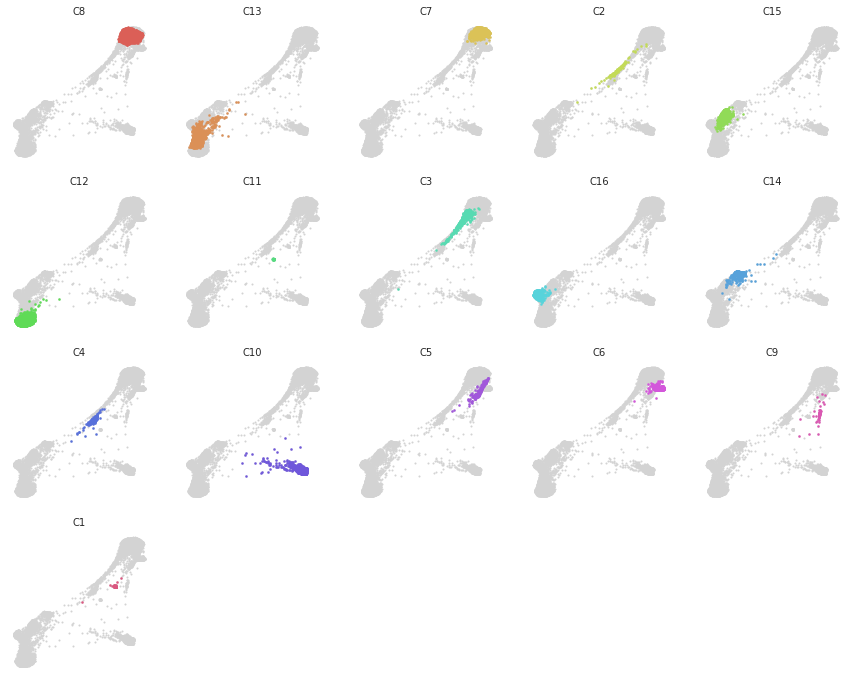

In [28]:
palantir.plot.cell_types(fdl, ad.obs['Clusters'])

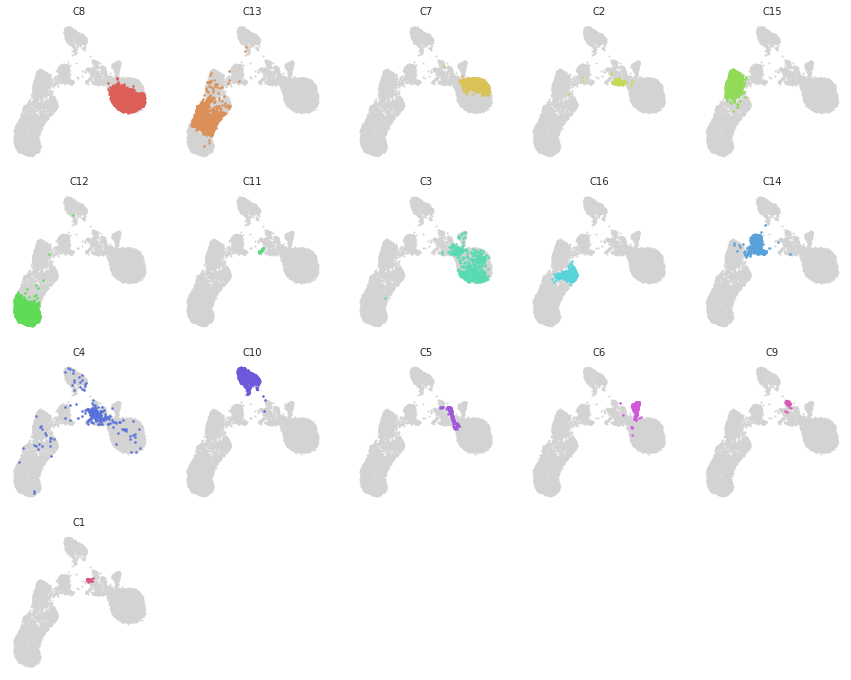

In [29]:
palantir.plot.cell_types(umap, ad.obs['Clusters'])

# Save

In [30]:
from scipy.sparse import csr_matrix
ad.X = csr_matrix(ad.X)

In [31]:
ad.write(data_dir +'pbmcs_10k.h5ad')

... storing 'Sample' as categorical
... storing 'Clusters' as categorical
... storing 'AP-GFP' as categorical
... storing 'Replicate' as categorical
... storing 'nearestGene' as categorical
... storing 'peakType' as categorical
... storing 'nearestTSS' as categorical
